In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

from delensalot.core import cachers

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x**2 / (aa * bb)
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    

def load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx = 0):
    #input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_olm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_alpha_lm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    inputs = {}
    print("Inputs in", f"{scratch}/{cmbversion}")
    for k in selected:
        input = hp.read_alm(f"{scratch}/{cmbversion}/simswalpha/{input_names[k]}.fits")
        inputs[k] = utils.alm_copy(input, lmax=lmax_rec)
    return inputs


# Function to process a configuration and prepare data for plotting
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin = config["imin"]
    simidx = imin
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

In [22]:
def process_config_npy(config_path):

    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/joint_map_outputs/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin, imax = config["imin"], config["imax"]
    itmax = config["itmax"]
    qe_key = config["k"]

    its_file = f"{scratch}/total_qe_it_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    autoits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    crossits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_down_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        crossits_down = np.load(its_file)
    else:
        crossits_down = 0

    its_file = f"{scratch}/input_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    auto_input_its = np.load(its_file)

    its_file = f"{scratch}/input_down_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        auto_input_down_its = np.load(its_file)
    else:
        auto_input_down_its = 0


    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    
    return selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its



In [5]:
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    simidx = config["imin"]
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"

    print("Reading from", its_folder)

    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

    

In [6]:
def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config(config_path, itrs, subset_selected) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = True, outdir = "../plots/")

    for i, k in enumerate(subset_selected):  # Iterate over estimators
        for j, (selected, _, plms, inputs, _, title) in enumerate(config_data):  # Iterate over configurations
            original_idx = selected.index(k)

            for idx, itr in enumerate(itrs):  # Iterate over iterations
                splits = np.split(plms[idx], len(selected))
                el, cross = cross_corr_coeff(splits[original_idx], inputs[k], plot=False)
                plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)

            plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f" ({names_fields[k]})", row=i, col=j)

            plot.set_scale(xscale="log", row=i, col=j)
            if i == 0:
                plot.set_title(title, row=i, col=j)
                if j == 0:
                    plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

Reading from /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//alpha_phi_omega_cmb_version_alpha_disabled_phi_omega_mv_mv_recs/p_sim0121alpha_disabled_phi_omega_mv_mv/
Inputs in /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//alpha_phi_omega_cmb
Reading from /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//alpha_phi_omega_cmb_version_alpha_phi_omega_recs/p_p_sim0000alpha_phi_omega/
Inputs in /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//alpha_phi_omega_cmb
Reading from /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//alpha_phi_omega_cmb_version_alpha_disabled_phi_omega_recs/p_p_sim0000alpha_disabled_phi_omega/
Inputs in /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//alpha_phi_omega_cmb


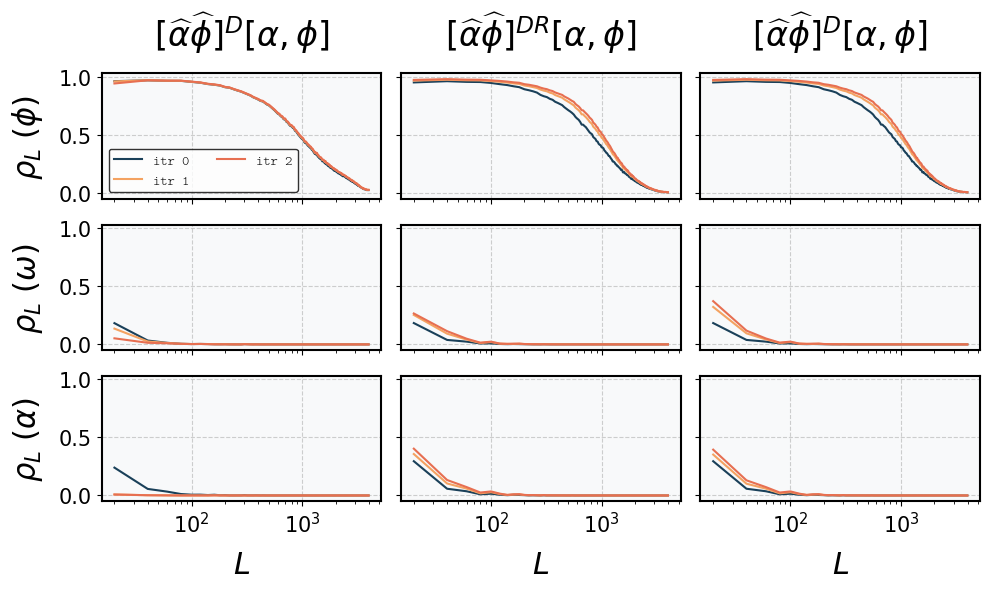

In [7]:
config_paths = ["check_mv", "config_full_alpha_lensing_cmb_s4", "config_full_alpha_disabled_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

subset_selected = ["p", "o", "a"]
itrs = [0, 1, 2]#, 1, 5, 15]
outname = "d"

plot_configs_with_class(config_paths, subset_selected, itrs, outname)

## Showing noise levels

In [8]:
from os.path import join as opj
import os
from plancklens import utils

import matplotlib.pyplot as plt


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]


##also, get some theory calculation for comparison
from plancklens import nhl, n0s, qresp

qe_key = "p_p"

nlev_t = 1.
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = 1.
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = lmin_cmb, lmin_cmb, lmin_cmb
lmax_cmb = 4000
itermax = 1
ret_curl = True

lmax_qlm = 5120

lt, le, lb = (np.arange(lmax_cmb + 1) >= lmin_tlm), (np.arange(lmax_cmb + 1) >= lmin_elm), (np.arange(lmax_cmb + 1) >= lmin_blm)

transf = hp.gauss_beam(beam_fwhm / 180 / 60 * np.pi, lmax=lmax_cmb)
ftl = utils.cli(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
fel = utils.cli(cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
fbl = utils.cli(cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
fals = {'tt':ftl, 'ee':fel, 'bb':fbl}
dat_cls = {'tt':(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
            'ee': (cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
               'bb': (cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}

cls_ivfs_arr = utils.cls_dot([fals, dat_cls, fals])

cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

nggs = {}
for source in ["p", "a"]:
    qe_key = f"{source}_p"

    GG_N0, CC_N0 = nhl.get_nhl(qe_key, qe_key, cls_len, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out = lmax_qlm)[0:2]

    r_gg_fid, r_cc_fid = qresp.get_response(qe_key, lmax_cmb, source, cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]

    n_gg = GG_N0 * utils.cli(r_gg_fid ** 2)

    nggs[source] = n_gg

    if source == "p":
        nggs["o"] = CC_N0*utils.cli(r_cc_fid ** 2)


In [9]:
from delensalot.biases import iterbiasesN0N1

qe_key = 'p_p'

cachedir = 'n0n1_cachedir_200_new_so'
nlev_t, nlev_p, beam_fwhm = 7, 7*np.sqrt(2), 1.4
itbias = iterbiasesN0N1.iterbiases(nlev_t, nlev_p, beam_fwhm, (lmin_cmb, lmin_cmb, lmin_cmb), lmax_cmb,
                                    lmax_qlm, cls_unl_fid, None, cachedir, verbose=True)
N0s_iter = {}
N1s_iter = {}
rggs_iter = {}
for itermax in [0, 5, 10]:
    A, del_cls, dat_del_cls = itbias.get_n0n1(qe_key, itermax, None, None, version = "wN1")
    N0s, N1s, rgg, _ = A
    N0s_iter[itermax] = N0s
    N1s_iter[itermax] = N1s
    rggs_iter[itermax] = rgg

lmin_tlm:30, lmin_elm:30, lmin_blm:30
Filtering with gaussian beam and fiducial noise levels


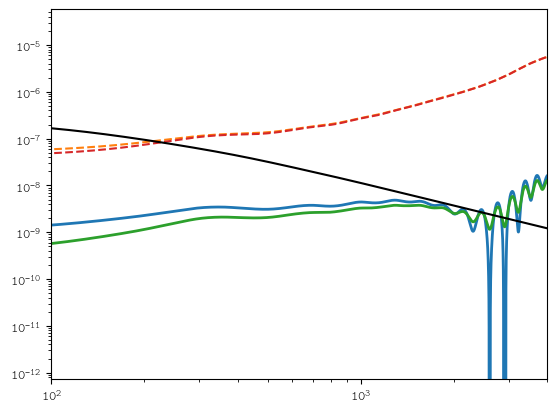

In [10]:
ls = np.arange(N1s_iter[itermax].size)
factor = ls*(ls+1)/2
for itermax in [0, 10]:
    plt.loglog(N1s_iter[itermax]*factor**2, lw = 2)
    plt.loglog(N0s_iter[itermax]*factor**2, ls = "--")
plt.plot(cls_unl["pp"][:ls.size]*factor**2, color = "black")
plt.xlim(100, 4000)
plt.savefig("n1.png", dpi = 300)

In [11]:
import numpy as np

def n1_beta_beta(L, cls_unl, dat_cls, fals, lmax_cmb):
    """
    Calculate n_L^(1),ββ for CMB lensing noise calculation using real spectra.
    
    Args:
        L (array): Multipole array
        cls_unl (dict): Unlensed CMB power spectra
        dat_cls (dict): Data (observed) power spectra including noise
        fals (dict): Filtering functions
        lmax_cmb (int): Maximum CMB multipole for summation
    """
    # Truncate spectra to lmax_cmb
    cls_ee = cls_len['ee'][:lmax_cmb + 1]
    cls_bb = cls_len['bb'][:lmax_cmb + 1]
    cls_pp = cls_unl['pp'][:lmax_cmb + 1]
    
    # Convert lensing potential to convergence power spectrum
    ell = np.arange(cls_pp.size)
    conv_factor = np.zeros_like(ell, dtype=float)
    conv_factor[1:] = (ell[1:] * (ell[1:] + 1) / 2) ** 2  # Avoid l=0
    cls_kk = cls_pp * conv_factor
    
    # Get the filtered spectra
    cls_ee_dat = dat_cls['ee']
    cls_bb_dat = dat_cls['bb']
    
    # Apply the filtering
    filtered_ee = cls_ee
    filtered_bb = cls_bb
    
    # First sum over L'
    sum_L = np.zeros_like(L, dtype=float)

    ls = np.arange(0, lmax_cmb + 1)

    for L in range(1, lmax_cmb + 1):  # Start from 1 to avoid division by zero

        Lp = 2*lmax_cmb-L

        mask = (ls >= Lp//2) & (ls <= lmax_cmb)
        mask *= (cls_ee_dat > 0)

        factor = ((2*ls[mask] + 1)/(4*np.pi))*(filtered_ee[mask]/cls_ee_dat[mask] * filtered_ee[mask]/cls_bb_dat[mask])**2
        factor = np.sum(factor)

        Lp = L

        sum_L[L-1] += ((2*Lp + 1)/(4*np.pi)) * cls_kk[Lp] * 0.5 * \
                ((Lp-1)*(Lp+2))/(Lp*(Lp+1))
        
        sum_L[L-1] *= factor        
    
    # Second sum over l (where 2l ≥ L')
    
    """sum_l = np.zeros_like(L, dtype=float)
    for l in range(lmax_cmb + 1):
        mask = (2*l >= L) & (cls_ee_dat[l] != 0) & (cls_bb_dat[l] != 0)
        if np.any(mask):
            sum_l[mask] += ((2*l + 1)/(4*np.pi)) * \
                          (filtered_ee[l]/cls_ee_dat[l] * filtered_ee[l]/cls_bb_dat[l])**2"""
    
    return 4 * sum_L #* sum_l

def n0_beta_beta_inverse(L, cls_unl, dat_cls, fals, lmax_cmb):
    """
    Calculate 1/N_L^(0)ββ for CMB lensing noise calculation using real spectra.
    
    Args:
        L (array): Multipole array
        cls_unl (dict): Unlensed CMB power spectra
        dat_cls (dict): Data (observed) power spectra including noise
        fals (dict): Filtering functions
        lmax_cmb (int): Maximum CMB multipole for summation
    """
    # Truncate spectrum to lmax_cmb
    cls_ee = cls_len['ee'][:lmax_cmb + 1]
    
    # Get the filtered spectra
    filtered_ee = cls_ee
    
    cls_ee_dat = dat_cls['ee']
    cls_bb_dat = dat_cls['bb']
    
    result = np.zeros_like(L, dtype=float)
    
    for l in range(lmax_cmb + 1):
        if cls_ee_dat[l] != 0 and cls_bb_dat[l] != 0:
            result += ((2*l + 1)/(4*np.pi)) * \
                     ((filtered_ee[l]/cls_ee_dat[l]) * (filtered_ee[l]/cls_bb_dat[l]))
    
    return 4 * result

def calculate_noise_terms(lmax_cmb, cls_unl, dat_cls, fals):
    """
    Calculate both noise terms using the provided spectra and filters.
    
    Args:
        lmax_cmb (int): Maximum CMB multipole
        cls_unl (dict): Unlensed CMB power spectra
        dat_cls (dict): Data (observed) power spectra including noise
        fals (dict): Filtering functions
        
    Returns:
        tuple: (n1_bb, n0_bb_inv) arrays
    """
    L = np.arange(lmax_cmb + 1)
    
    # Calculate N1 term
    n1_bb = n1_beta_beta(L, cls_unl, dat_cls, fals, lmax_cmb)
    
    # Calculate inverse N0 term
    n0_bb_inv = n0_beta_beta_inverse(L, cls_unl, dat_cls, fals, lmax_cmb)
    
    return n1_bb, n0_bb_inv**-1.

n1_bb, n0_bb = calculate_noise_terms(lmax_cmb, cls_unl, dat_cls, fals)

In [51]:
config_paths = ["config_full_alpha_lensing_cmb_s4", "config_full_alpha_disabled_lensing_cmb_s4", "config_full_alpha_no_curl_lensing_cmb_s4", "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]


config_paths = ["config_full_alpha_disabled_lensing_cmb_s4"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths

['configs/config_full_alpha_disabled_lensing_cmb_s4.yaml']

In [52]:
#bin_edges = np.arange(1, 4000, 2)
bin_edges_A = np.arange(1, 10, 1)
bin_edges_B = np.arange(10, 500, 100)
bin_edges = np.concatenate([bin_edges_A, bin_edges_B, np.arange(500, 4000, 200)])

decorator = lambda x: bin_theory(x, bin_edges)


In [53]:
selected = ["a", "p", "o"]

In [54]:
simnumber = 70
directory = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim{simnumber:04}test_randomizing_new/"

root = "plm_gradplik_it000"
#root = "phi_plm_it000"
#roots = ["plm_gradplik_it000", "phi_plm_it000"]

roots = ["phi_plm_it000"]+[f"hessian/rlm_sn_{i}_p" for i in range(3)]

#roots = ["plm_gradplik_it000"]

alpha_lm = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new/simswalpha/sim_0070_alpha_lm.fits")
alpha_lm = utils.alm_copy(alpha_lm, lmax = lmax_qlm)
fs = np.cumsum([np.load(directory+f"{root}.npy") for root in roots], axis = 0)
fs1000 = np.cumsum([np.load(directory+f"{root}_1000_1000.npy") for root in roots], axis = 0)

/tmp/ipykernel_17130/525077618.py:16: RuntimeWarning: invalid value encountered in divide
  WF = -cross_split[i][itr]/inputs[i]


b


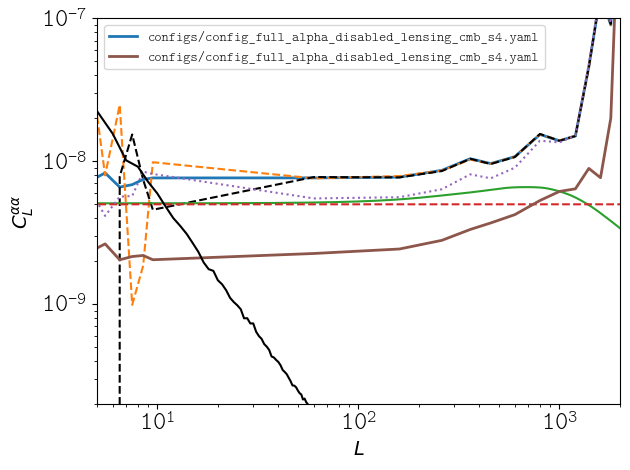

In [55]:
invWFs = {}

for i, s in enumerate(selected[:1]):

    for j, config_path in enumerate(config_paths):
        selected, autoits, crossits, auto_input_its, _, _ = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        for itr in [0, autos.shape[0]-1]:
            WF = -cross_split[i][itr]/inputs[i]
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]
            el, x = decorator(xx)
            plt.loglog(el, x, lw = 2, label= config_path)

            if itr == 0:
                i = 0
                xx = 0
                ff = np.split(fs[i], 3)[xx]
                ff1000 = np.split(fs1000[i], 3)[xx]
                xx = hp.alm2cl(ff)[:5001]*invWFs[s]**2-inputs[i]
                el, x = decorator(xx)
                plt.loglog(el, x, ls = "--")

                xx = autoits[0][0][:5001]*invWFs[s]**2-inputs[i]
                el, x = decorator(xx)
                plt.loglog(el, x, ls = "--", color = "black")

                plt.plot(nggs["a"])
                plt.plot(n0_bb, ls = "--")

                xx = hp.alm2cl(ff1000)[:5001]*invWFs[s]**2
                el, x = decorator(xx)
                plt.loglog(el, x, ls = ":")



        plt.plot(inputs[i], color = "black")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        print(a)
        plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        plt.ylim(2e-10, 1e-7)
        plt.tight_layout()
        plt.legend()
        plt.savefig("alpha.png", dpi = 300)
    plt.show()

/tmp/ipykernel_17130/2759033551.py:7: RuntimeWarning: invalid value encountered in divide
  correction = hp.alm2cl(alpha_lm)/hp.alm2cl(alpha_lm, ff)


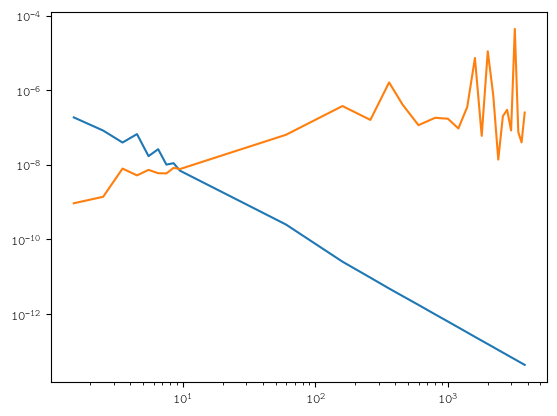

In [35]:
i = 0
xx = 0

ff = np.split(fs[i], 3)[xx]
ff1000 = np.split(fs1000[i], 3)[xx]

correction = hp.alm2cl(alpha_lm)/hp.alm2cl(alpha_lm, ff)

N0 = hp.alm2cl(ff1000)*correction**2

input = hp.alm2cl(alpha_lm)
el, clth = decorator(input)
plt.loglog(el, clth)
el, cl = decorator(hp.alm2cl(ff)*correction**2-input)
plt.loglog(el, cl)

In [46]:
bin_edges = np.arange(0, 1500, 10)
def cross_corr_coeff_new(a1a2, a1, a2, base=0, color=None, plot=True, ax=None, label=None, linestyle = None):
    ls = np.arange(len(a1))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(a1a2)
    el, aa = decorator(a1)
    el, bb = decorator(a2)
    xcorr = x**2 / (aa * bb)
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label, linestyle = linestyle)
    return el, xcorr

In [47]:
config_paths = ["config_full_cmb_s4",  "config_full_a_d_disabled_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=len(selected), figsize = (16, 6), sharex = True)

names = {"o": r"$\hat{\omega}$", "a": r"$\hat{\alpha}$", "p": r"$\hat{\phi}$", "f": r"$\hat{\tau}$"}
names_down = {"o": r"$\hat{\omega}-\alpha$", "a": r"$\hat{\alpha}-\omega$", "p": r"$\hat{\phi}-\tau$", "f": r"$\hat{\tau}-\phi$"}

colors = {0: "blue", 1: "red", 2: "green"}
lines = {0: "-", 1: "--"}

labels = lambda x: "QE" if x == 0 else "MAP"


for j, config_path in enumerate(config_paths):
    selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its = process_config_npy(config_path)   


    autos = autoits.mean(axis = 0)
    crosses = crossits.mean(axis = 0)
    crosses_down = crossits_down.mean(axis = 0)
    inputs = auto_input_its.mean(axis = 0)
    inputs_down = auto_input_down_its.mean(axis = 0)

    autos_split = np.split(autos, len(selected), axis = -1)
    cross_split = np.split(crosses, len(selected), axis = -1)
    cross_down_split = np.split(crosses_down, len(selected), axis = -1)

    for i, s in enumerate(selected):
        ax = axs[0, i]
        ax.set_title(names[s], fontsize = 20)
        a1 = inputs[i]
        for itr in [0, 11]:
            a2 = autos_split[i][itr]
            a12 = cross_split[i][itr]
            
            if itr == 0:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = "green", label = labels(itr))
            else:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = colors[j], label = labels(itr))
        if (i == 0) and (j == 0):
            ax.legend()
        ax.set_xscale("log")
        ax.set_xlim(1, 3000)
        ax.tick_params(axis='both', labelsize=18)

        ax = axs[1, i]
        ax.set_title(names_down[s], fontsize = 20)
        a1 = inputs_down[i]
        for itr in [0, 15]:
            a2 = autos_split[i][itr]
            a12 = cross_down_split[i][itr]
            if itr == 0:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = "green", label = labels(itr))
            else:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = colors[j], label = labels(itr))

        ax.set_xscale("log")
        ax.set_xlim(5, 3000)
        ax.tick_params(axis='both', labelsize=18)


fig.tight_layout()
plt.savefig("cross-corr.png", dpi = 300)
plt.show()

In [ ]:
for i, s in enumerate(selected):

    for j, config_path in enumerate(config_paths):
        selected, autoits, crossits, auto_input_its = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        for itr in [0, autos.shape[0]-1]:
            WF = -cross_split[i][itr]/inputs[i]
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]
            el, x = decorator(xx)
            plt.loglog(el, x, lw = 2, label= config_path)
        plt.plot(inputs[i], color = "black")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        print(a)
        plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        plt.ylim(2e-10, 1e-7)
        plt.tight_layout()
        plt.legend()
        plt.savefig("alpha.png", dpi = 300)
    plt.show()